# Netflix Recommender Using K Nearest Neighbors

### import packages

In [19]:
import pandas as pd
import tqdm
from tqdm import tqdm

import spacy

### Data Exploration

My goal is to create a simple Machine Learning Model that enables the user to input their desired movie description and recieve a list of movie recommendations. The first step of this process is to use a dataset that includes Movie Titles and their respective descriptions. Luckily, Netflix has provided this dataset.

In [4]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [5]:
df.shape

(6234, 12)

In [6]:
df['type'].value_counts()

Movie      4265
TV Show    1969
Name: type, dtype: int64

In [7]:
df['country'].value_counts()

United States                         2032
India                                  777
United Kingdom                         348
Japan                                  176
Canada                                 141
                                      ... 
United Kingdom, Pakistan                 1
Iran, France                             1
South Africa, China, United States       1
Lebanon, Jordan                          1
Spain, Cuba                              1
Name: country, Length: 554, dtype: int64

In [8]:
df = df[(df['type'] == 'Movie') & (df['country'] == 'United States')]
df = df.reset_index(drop=True)
df.shape

(1482, 12)

In [9]:
df.isnull().sum()

show_id           0
type              0
title             0
director         40
cast            145
country           0
date_added        0
release_year      0
rating            3
duration          0
listed_in         0
description       0
dtype: int64

The Netflix dataset includes an assortment of Movies and TV-Shows from many Countries. I wanted to target only Movies in the United States, so the dataset reduces from 6234 to 1482 obervations.

In [10]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
1,80060297,Movie,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",United States,"September 8, 2017",2014,TV-14,98 min,"Comedies, Independent Movies, Romantic Movies",A filmmaker working on a documentary about lov...
2,70304988,Movie,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",United States,"September 8, 2017",2014,PG-13,113 min,"Horror Movies, Thrillers","In 1899, a young doctor arrives at an asylum f..."
3,80057700,Movie,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",United States,"September 8, 2017",2015,R,90 min,"Dramas, Independent Movies",A New Orleans politician finds his idealistic ...
4,80045922,Movie,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",United States,"September 8, 2015",2015,NR,80 min,"Dramas, Independent Movies, Romantic Movies",As a volatile young couple who have been toget...


### Testing out Spacy on 1 Review

In [10]:
df['description'][0]

'When nerdy high schooler Dani finally attracts the interest of her longtime crush, she lands in the cross hairs of his ex, a social media celebrity.'

In [11]:
doc = nlp(df['description'][0])
doc

When nerdy high schooler Dani finally attracts the interest of her longtime crush, she lands in the cross hairs of his ex, a social media celebrity.

In [12]:
doc = [token.lemma_ for token in doc if (token.is_stop == False) and (token.is_punct == False)]
doc

['nerdy',
 'high',
 'schooler',
 'Dani',
 'finally',
 'attract',
 'interest',
 'longtime',
 'crush',
 'land',
 'cross',
 'hair',
 'ex',
 'social',
 'medium',
 'celebrity']

In [13]:
list1 = pd.Series([" 1", "2", ' 3'])
list1 = list1.apply(lambda x:x.strip())
list1[2]

'3'

### Tokenize, Remove Stop words, and Punct

Before vectorizing the Movies descriptions, I had to apply two preprocessing steps to lowercase and remove whitespace. I also combined the 'listed_in' and 'description' columns. Then I used Spacy's pretrained NLP model (en_core_web_lg) to lemmatize, remove stop words, and punctuations.

In [11]:
df['description']=df['description'].apply(lambda x:x.lower())
df['listed_in']=df['listed_in'].apply(lambda x:x.lower())

df['description']=df['description'].apply(lambda x:x.strip())
df['listed_in']=df['listed_in'].apply(lambda x:x.strip())

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,comedies,when nerdy high schooler dani finally attracts...
1,80060297,Movie,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",United States,"September 8, 2017",2014,TV-14,98 min,"comedies, independent movies, romantic movies",a filmmaker working on a documentary about lov...
2,70304988,Movie,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",United States,"September 8, 2017",2014,PG-13,113 min,"horror movies, thrillers","in 1899, a young doctor arrives at an asylum f..."
3,80057700,Movie,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",United States,"September 8, 2017",2015,R,90 min,"dramas, independent movies",a new orleans politician finds his idealistic ...
4,80045922,Movie,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",United States,"September 8, 2015",2015,NR,80 min,"dramas, independent movies, romantic movies",as a volatile young couple who have been toget...


In [ ]:
nlp = spacy.load("en_core_web_lg")

In [28]:
#Extract tokens from reviews using Spacy
# nlp.Defaults.stop_words |= {"my_new_stopword1","my_new_stopword2",}

other_words = ['movie','find',' movie', 'movie ', ' movie ', 'movies']

tokens = []

for index,row in tqdm(df.iterrows()):
    description = row['description']
    listed_in = row['listed_in']
    doc = description + listed_in
    doc = nlp(doc)
    doc = [token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True) and (str(token) not in other_words)]
    tokens.append(doc)

1482it [00:15, 96.07it/s]


In [29]:
tokens[0]

['nerdy',
 'high',
 'schooler',
 'dani',
 'finally',
 'attract',
 'interest',
 'longtime',
 'crush',
 'land',
 'cross',
 'hair',
 'ex',
 'social',
 'medium',
 'celebrity.comedie']

In [30]:
df['tokens'] = tokens
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,tokens
0,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,comedies,when nerdy high schooler dani finally attracts...,"[nerdy, high, schooler, dani, finally, attract..."
1,80060297,Movie,Manhattan Romance,Tom O'Brien,"Tom O'Brien, Katherine Waterston, Caitlin Fitz...",United States,"September 8, 2017",2014,TV-14,98 min,"comedies, independent movies, romantic movies",a filmmaker working on a documentary about lov...,"[filmmaker, work, documentary, love, modern, m..."
2,70304988,Movie,Stonehearst Asylum,Brad Anderson,"Kate Beckinsale, Jim Sturgess, David Thewlis, ...",United States,"September 8, 2017",2014,PG-13,113 min,"horror movies, thrillers","in 1899, a young doctor arrives at an asylum f...","[1899, young, doctor, arrive, asylum, apprenti..."
3,80057700,Movie,The Runner,Austin Stark,"Nicolas Cage, Sarah Paulson, Connie Nielsen, W...",United States,"September 8, 2017",2015,R,90 min,"dramas, independent movies",a new orleans politician finds his idealistic ...,"[new, orlean, politician, find, idealistic, pl..."
4,80045922,Movie,6 Years,Hannah Fidell,"Taissa Farmiga, Ben Rosenfield, Lindsay Burdge...",United States,"September 8, 2015",2015,NR,80 min,"dramas, independent movies, romantic movies",as a volatile young couple who have been toget...,"[volatile, young, couple, year, approach, coll..."


In [31]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

In [32]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [33]:
wc = count(df['tokens'])

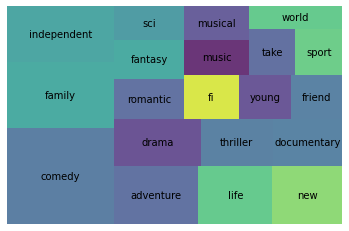

In [34]:
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

Here I plotted the top 20 most frequent words in the corpus.

### Vectorize Tokens (TFIDF)

Now that the new Movie descriptions are clean and tokenized in another column called 'tokens'. we are ready to vectorize. In my TF-IDF vectorizer, I included the following hyperparameters:
>  n_gram_range=(1,2): Helps perserve the context of the movie description with 2 linked words

>  max_df=0.97 and min_df=2: Helps trim down my vocab to words that appear in at most 97% and at least 2 of the documents

>  max_features=1000: Best 3000 words/2-grams combinations

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2),
                      max_df=0.97,
                      min_df=2,
                      max_features = 3000)

description = df['tokens'].astype(str)

dtm = tfidf.fit_transform(description)

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,000,000 year,10,10 year,100,11,11 year,12,12 year,13,...,youth,youtube,youtube sensation,yuppie,zach,zach galifianakis,zack,zion,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### K-NearestNeighbor

In [38]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [39]:
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 1.23238215, 1.23627091, 1.24601841, 1.26335832]]),
 array([[   0,  751, 1150,  899,  883]]))

In [40]:
nn.kneighbors([dtm.iloc[0]])

(array([[0.        , 1.23238215, 1.23627091, 1.24601841, 1.26335832]]),
 array([[   0,  751, 1150,  899,  883]]))

### Query Movie Recommender

In [53]:
movie = ["Four teenagers are sucked into a magical video game, and the only way they can escape is to work together to finish the game."]

In [54]:
new = tfidf.transform(movie)

In [55]:
new

<1x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [56]:
nn.kneighbors(new.todense())

(array([[1.06911197, 1.16598473, 1.19431197, 1.20707636, 1.22899886]]),
 array([[ 704,  238, 1425, 1186, 1454]]))

In [57]:
recommendations = nn.kneighbors(new.todense())[1].tolist()[0]
recommendations

[704, 238, 1425, 1186, 1454]

In [61]:
df[['type','title','cast','listed_in','description']].iloc[recommendations]

,type,title,cast,listed_in,description
704,Movie,Ralph Breaks the Internet: Wreck-It Ralph 2,"John C. Reilly, Sarah Silverman, Taraji P. Hen...","children & family movies, comedies",when video-game bad guy ralph and best friend ...
238,Movie,Barbie: Video Game Hero,"Erica Lindbeck, Sienna Bohn, Shannon Chan-Kent...",children & family movies,"pulled into her favorite video game, barbie be..."
1425,Movie,Bigger Fatter Liar,"Ricky Garcia, Jodelle Ferland, Barry Bostwick,...","children & family movies, comedies",when his video game concept is stolen by a dis...
1186,Movie,Black Mirror: Bandersnatch,"Fionn Whitehead, Will Poulter, Craig Parkinson...","dramas, international movies, sci-fi & fantasy","in 1984, a young programmer begins to question..."
1454,Movie,Spy Kids 3: Game Over,"Daryl Sabara, Sylvester Stallone, Ricardo Mont...","children & family movies, comedies",carmen gets caught in a virtual reality game d...


### Export model

In [32]:
import pickle

filename = 'vect_01.pkl'
pickle.dump(tfidf, open(filename, 'wb'))

filename = 'knn_01.pkl'
pickle.dump(nn, open(filename, 'wb'))